# 전처리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split

In [2]:
!pip install pydot

import pydot
from IPython.core.display import Image 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dbt = pd.read_csv('/content/drive/Othercomputers/내 PC/DEV/DSL/정규세션/02. Decision Tree/diabetes.csv')

In [7]:
dbt.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
dbt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- 종속변수 = Outcome
- 결측치 없음

In [11]:
X = dbt.drop(['Outcome'], axis=1)
y = dbt[['Outcome']] # 두번 씌우면 DataFrame (안씌우면 Series)

In [10]:
print(X.columns)
print(X.shape)

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')
(768, 8)


In [12]:
print(y.columns)
print(y['Outcome'].unique())
print(y.shape)

Index(['Outcome'], dtype='object')
[1 0]
(768, 1)


# Pruning 이전

- Train, Test 구분

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

- 트리 생성

In [14]:
clf_1 = DecisionTreeClassifier(random_state=0)
tree_nottuned = clf_1.fit(X_train, y_train)

In [15]:
def draw_decision_tree(clf, feature_names = None, class_names = None):
    dot_data = export_graphviz(clf, out_file = None, 
                                feature_names = feature_names,
                                class_names = class_names,
                                filled = True, 
                                rounded = True,
                                special_characters = True)
    graph = pydot.graph_from_dot_data(dot_data)[0]
    image = graph.create_png()
    return Image(image)

In [16]:
draw_decision_tree(tree_nottuned, X.columns, y.columns[0])

Output hidden; open in https://colab.research.google.com to view.

- Overfitting 되었을 것으로 추정됨

# 사전 가지치기

In [17]:
from sklearn.model_selection import GridSearchCV

hyperparamters = {'max_depth': list(range(2, 8)),  'min_samples_split': list(range(5, 30)), 'max_leaf_nodes': list(range(5, 15))}

# GridSearch 진행
GridCV = GridSearchCV(estimator=tree_nottuned, param_grid=hyperparamters, cv=5, verbose=1)

In [18]:
GridCV.fit(X_train, y_train)
GridCV.best_params_ # 가장 좋은 성능을 보였을 때의 parameter

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


{'max_depth': 4, 'max_leaf_nodes': 5, 'min_samples_split': 5}

## 트리 시각화

In [19]:
clf_2 = DecisionTreeClassifier(max_depth=4, min_samples_split=5, max_leaf_nodes=5, random_state=0)
tree_pre_tuned = clf_2.fit(X_train, y_train)

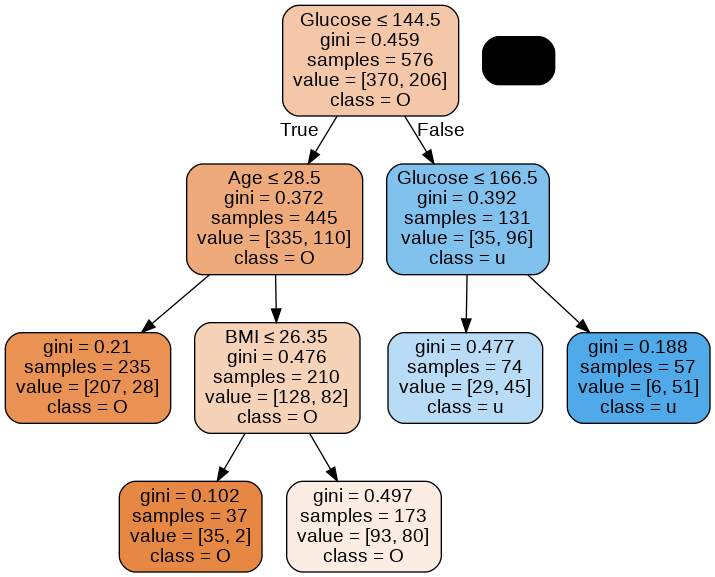

In [20]:
draw_decision_tree(tree_pre_tuned, X.columns, y.columns[0])

## Accuracy 비교

In [22]:
from sklearn.metrics import accuracy_score

y_pred=clf_1.predict(X_test)
print("No Tuning : Accuracy =", accuracy_score(y_pred,y_test))

No Tuning : Accuracy = 0.71875


In [23]:
y_pred=clf_2.predict(X_test)
print("Pre Tuning : Accuracy =", accuracy_score(y_pred,y_test))

Pre Tuning : Accuracy = 0.75


- Pre-Pruning을 통해 Overfitting을 줄일 수 있었으며, Accuracy도 0.71875에서 0.75로 상승하였음을 확인할 수 있다.
(max_depth=4, min_samples_split=5, max_leaf_nodes=5)

# 사후 가지치기

In [24]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [25]:
clf = DecisionTreeClassifier(random_state=0)

path = clf.cost_complexity_pruning_path(X_train, y_train)

# effective alphas, corresponding total leaf impurities 구하기
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

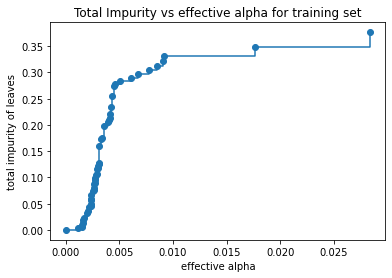

In [26]:
# effective alpha값에 따른 total impurity of leaves 그래프

fig, ax = plt.subplots()

# ccp_alphas[-1]은 노드가 하나밖에 없는 트리임.
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# alpha 값이 커지면 트리가 작아짐 -> total impurity of leaves 커짐

In [27]:
clfs = []
count = 0
for ccp_alpha in ccp_alphas:
    # 각 effective alphas 이용해 decision tree 만들기
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf = clf.fit(X_train, y_train)
    count += 1
    print("Number of nodes in the {}th tree is: {} with ccp_alpha: {}".format(
      count, clf.tree_.node_count, ccp_alpha))
    clfs.append(clf)

Number of nodes in the 1th tree is: 215 with ccp_alpha: 0.0
Number of nodes in the 2th tree is: 209 with ccp_alpha: 0.0011322463768115932
Number of nodes in the 3th tree is: 205 with ccp_alpha: 0.0015190972222222222
Number of nodes in the 4th tree is: 201 with ccp_alpha: 0.0015625000000000005
Number of nodes in the 5th tree is: 197 with ccp_alpha: 0.0016025641025641019
Number of nodes in the 6th tree is: 189 with ccp_alpha: 0.0016422672672672671
Number of nodes in the 7th tree is: 185 with ccp_alpha: 0.0017206101190476164
Number of nodes in the 8th tree is: 175 with ccp_alpha: 0.0019755747126436784
Number of nodes in the 9th tree is: 171 with ccp_alpha: 0.0020833333333333333
Number of nodes in the 10th tree is: 165 with ccp_alpha: 0.0021396553325901155
Number of nodes in the 11th tree is: 159 with ccp_alpha: 0.0023148148148148147
Number of nodes in the 12th tree is: 159 with ccp_alpha: 0.0023148148148148147
Number of nodes in the 13th tree is: 153 with ccp_alpha: 0.0023158575241908584


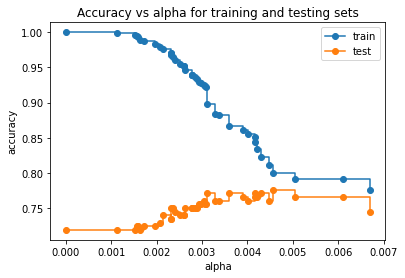

Decision tree without pruning : 215 nodes, 0.719 accuracy
Decision tree with the best pruning : 21 nodes, 0.776 accuracy


In [30]:
# 뒤의 세개 제외
clfs = clfs[:-3]
ccp_alphas = ccp_alphas[:-3]

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

print("Decision tree without pruning : {0} nodes, {1:.3} accuracy".format(tree_nottuned.tree_.node_count, tree_nottuned.score(X_test, y_test)))
print("Decision tree with the best pruning : {0} nodes, {1:.3} accuracy".format(clfs[test_scores.index(max(test_scores))].tree_.node_count, max(test_scores)))

## 트리 시각화

In [31]:
# testing accuracy를 높이는 최고의 ccp_alpha
clf_3 = DecisionTreeClassifier(random_state=0, ccp_alpha=0.0046)
tree_post_tuned = clf_3.fit(X_train, y_train)

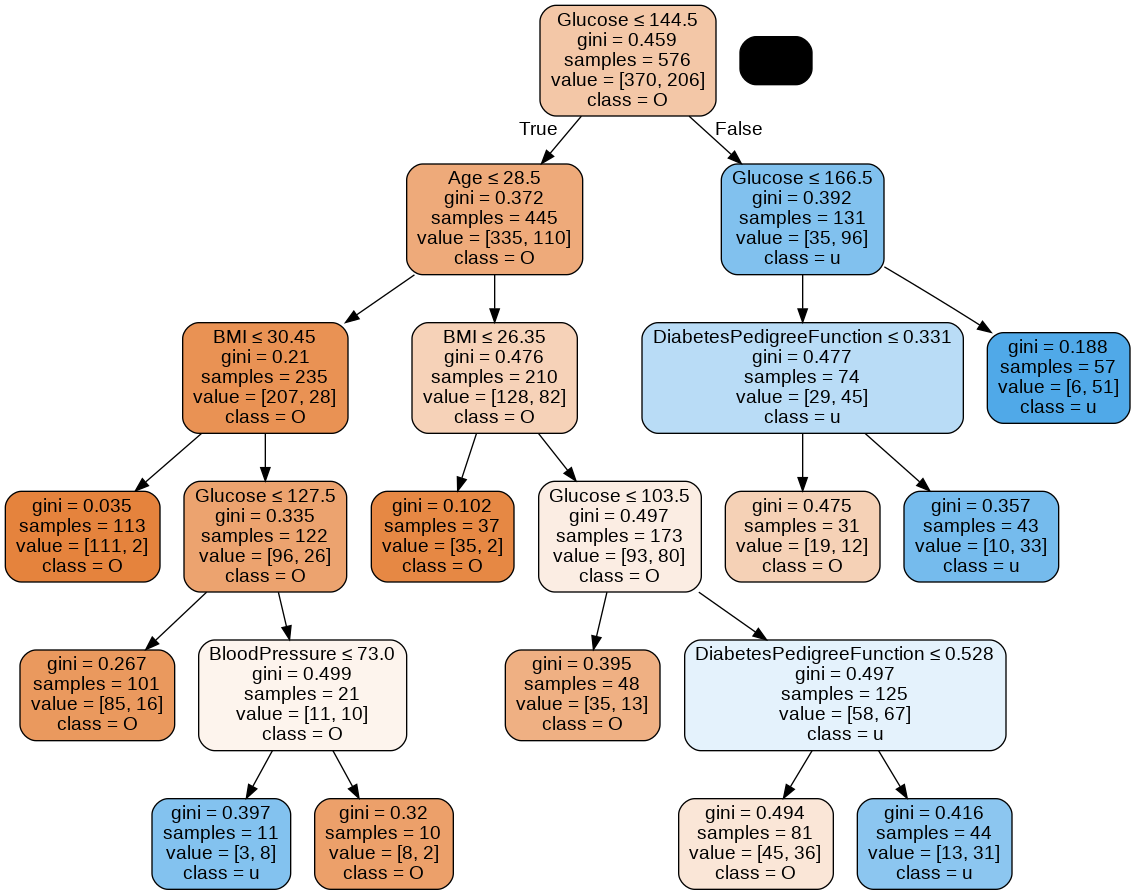

In [32]:
draw_decision_tree(tree_post_tuned, X.columns, y.columns[0])

## Accuracy 비교

In [33]:
y_pred=clf_1.predict(X_test)
print("No Tuning : Accuracy =", accuracy_score(y_pred,y_test))

No Tuning : Accuracy = 0.71875


In [34]:
y_pred=clf_3.predict(X_test)
print("Post Tuning : Accuracy =", accuracy_score(y_pred,y_test))

Post Tuning : Accuracy = 0.7760416666666666


- Post-Pruning을 통해 Overfitting을 줄일 수 있었으며, Accuracy도 0.71875에서 0.77604로 상승하였음을 확인할 수 있다.
(ccp_alpha=0.0046)